In [16]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from c_manipulations import *
from model import *

In [17]:
def c():
    rates = np.array([k_sol] + (2*nb_arms-2)*[0] + [k_off])
    for m in range(1, nb_arms):
        rates[m] = k_sur * k_on_scaling(nb_arms-m, a_on)
        rates[-1-m] = k_off * k_off_scaling(m+1, a_off)
        pass
    return rates


def settling_time(x_st):
    x_st *= np.array((nb_arms+1)*[n0]+[n0*nr])
    y = np.array([n0] + nb_arms * [0] + [n0 * nr])
    for j in range(round(np.log1p(1e10 * (base - 1)) / np.log(base))):
        if np.allclose(y, x_st, rtol=1e-2, atol=1e-1):
            return (base ** j - 1) / (base - 1)
        y = solve_ivp(time_evolution, (0, base ** j), y, args=(nb_arms, c()), method='Radau').y[:, -1]
        pass
    return -1


def steady_state_solution():
    result = np.zeros((len(nr_range), nb_arms+2))
    x = np.array([n0]+nb_arms*[0]+[n0*nr_range[0]])

    for i, rec in enumerate(nr_range):
        x = root(steady_state, x, args=(nb_arms, n0, rec, c())).x
        result[i] = x.copy()/n0
        result[i, -1] /= rec
        pass
    return result

In [18]:
def ssa_trajectory(x_st, st):
    data = k_nanostar(nb_arms, n0, nr, st, c()).run().to_array()[0, :, 1:]/np.array((nb_arms+1)*[n0]+[n0*nr])
    
    plt.figure()
    plt.plot(np.linspace(0, st, 1001), data)
    plt.xlabel("time (s)")
    plt.ylabel("fraction of possible (-)")
    plt.title("Gillespie trajectory")
    plt.legend([f"n$_{i}$" for i in range(nb_arms+1)] + ['receptors'])
    ss_result(x_st, st)
    pass


def ode_trajectory(x_st, st):
    sol = solve_ivp(time_evolution, (0, st), np.array([n0]+nb_arms*[0]+[n0*nr]), t_eval=np.linspace(0, st, 1000), args=(nb_arms, c()), method='Radau')
    
    plt.figure()
    plt.plot(sol.t, sol.y.transpose()/np.array((nb_arms+1)*[n0]+[n0*nr]))
    plt.xlabel("time (s)")
    plt.ylabel("fraction of possible (-)")
    plt.title("ODE trajectory")
    plt.legend([f"n$_{i}$" for i in range(nb_arms+1)] + ['receptors'])
    ss_result(x_st, st)
    pass


def ss_result(x_st, st):
    plt.hlines(x_st, 0, st, colors='k', linestyles='dashed', alpha=0.6)
    pass

In [19]:
def run():
    result = steady_state_solution()
    thetas = 1 - result[:, 0]
    alphas = np.log(thetas[1:] / thetas[:-1]) / np.log(nr_range[1]/nr_range[0])
    print(f"alpha_max: {alphas.max()}, theta_alpha_max: {thetas[alphas.argmax()]}")
    
    x_st = result[nr_idx]
    st = settling_time(x_st.copy())
    print(f"Settling time: {st}s")
    st = max(1, st)
    ode_trajectory(x_st, st)
    ssa_trajectory(x_st, st)
    pass

alpha_max: 3.2218008418458877, theta_alpha_max: 0.040007699570466126
Settling time: 2506.377186292721s


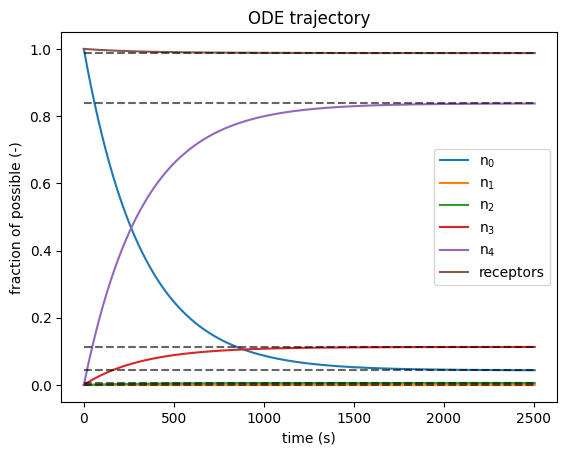

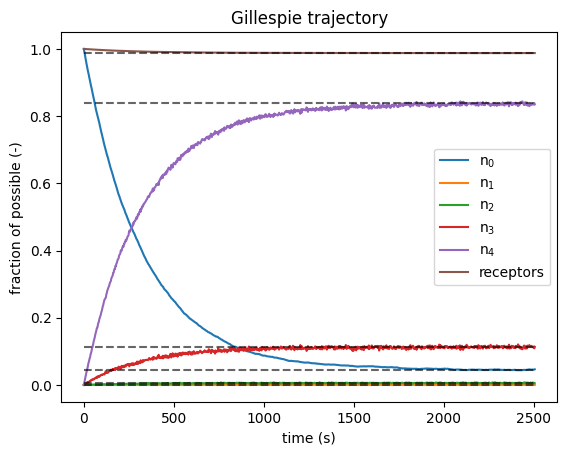

In [20]:
nr_range = np.logspace(-3, 5, 1000)
n0 = 10000
k_off = 1
base = 1.1

nb_arms = 4
k_sol = 1e-9
k_sur = 1e-5
nr = 3e2

nr_idx = np.searchsorted(nr_range, nr)
nr = nr_range[nr_idx]

k_on_scaling, a_on = power_law, 1
k_off_scaling, a_off = power_law, 1


run()